In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre12.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre12.npy'), allow_pickle=True)
train_labels = np.load(os.path.join(base_dir, 'train_labels_pre12.npy'))

val_data = np.load(os.path.join(base_dir, 'val_data_pre12.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre12.npy'), allow_pickle=True)
val_labels = np.load(os.path.join(base_dir, 'val_labels_pre12.npy'))

In [3]:
print('Training data shape: ', train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Training action shape: ', train_actions.shape)
print('Train Label=1 ratio:', np.sum(train_labels) /train_labels.shape[0])
print('Validation data shape: ', val_data.shape)
print('Validation label shape: ', val_labels.shape)
print('Validation action shape: ', val_actions.shape)
print('Validation Label=1 ratio:', np.sum(val_labels) / val_labels.shape[0])

Training data shape:  (1007, 12, 224, 224, 3)
Training label shape:  (1007,)
Training action shape:  (1007,)
Train Label=1 ratio: 0.24925521350546176
Validation data shape:  (433, 12, 224, 224, 3)
Validation label shape:  (433,)
Validation action shape:  (433,)
Validation Label=1 ratio: 0.2517321016166282


In [4]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

## Model 1: 3d Convolution

### 1.1 Define model

In [ ]:
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input

frames, channels, rows, columns = 12, 3, 224, 224

# 3D Convolutional Model:
input_model=Input(shape=(frames, rows, columns, channels))
layer=Conv3D(32,(3,3,3),strides=(1,1,1),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Conv3D(64,(3,3,3),strides=(1,1,1),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.1)(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer_output=Dense(8,activation='softmax')(layer)

model_3dConv=Model(input_model,layer_output)

model_3dConv.summary()

In [ ]:
import keras
from keras import optimizers
optimizer_adam = optimizers.Adam(lr=1e-3)

callbacks_list_conv_3d=[keras.callbacks.EarlyStopping(
monitor='accuracy',patience=10),
               keras.callbacks.ModelCheckpoint(
               filepath='conv_3d_model',
               monitor='val_loss',
               save_best_only=True),
                        keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10)
               ]
model_3dConv.compile(optimizer=optimizer_adam,loss='categorical_crossentropy',metrics=['accuracy'])

### 1.2 Train model

In [ ]:
history=model_3dConv.fit(train_data, 
                         train_action_labels,
                         batch_size=20, epochs=60,
                         validation_data=(val_data,val_action_labels),
                         callbacks=callbacks_list_conv_3d)

### 1.3 Plot train/valid accuracy & loss

In [ ]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [ ]:
## Zoom in train/valid loss after 10 epochs
import numpy as np
import os
base_dir = '/home/ubuntu'

model_1_cnn_3d_history = np.load(os.path.join(base_dir, "model_1_cnn_3d_history.npy"), allow_pickle=True)

acc=model_1_cnn_3d_history.item()["accuracy"]
val_acc=model_1_cnn_3d_history.item()["val_accuracy"]
loss=model_1_cnn_3d_history.item()["loss"]
val_loss=model_1_cnn_3d_history.item()["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs[10:], loss[10:], label = "Train", color = 'orchid')
plt.plot(epochs[10:], val_loss[10:], label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.ylim((1, 3))
plt.show()

### 1.4 Save model history

In [ ]:
###Save history
np.save(os.path.join(base_dir, "model_1_cnn_3d_history"), history.history)
###Save model
model_3dConv.save(os.path.join(base_dir, "conv_3d_model.h5"))

### 1.5.1 Evaluate on validation dataset

In [ ]:
model_3dConv = keras.models.load_model(os.path.join(base_dir, "conv_3d_model.h5"))
val_preds = model_3dConv.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
tn, fp, fn, tp = confusion_matrix.ravel()
prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

### 1.5.2 Evaluate model on test dataset

In [11]:
#Load test
base_dir = '/home/ubuntu'

test_data = np.load(os.path.join(base_dir, 'test_data_pre12.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre12.npy'), allow_pickle=True)

In [ ]:
# reshape data
#test_data = np.moveaxis(test_data, 2, -1)

In [ ]:
print('Test data shape: ', test_data.shape)
print('Test action shape: ', test_actions.shape)

In [ ]:
test_preds = model_3dConv.predict(test_data)

test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

## Model 2: CNN and LSTM

### 2.1 Define model

In [43]:
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import models

frames, channels, rows, columns = 12, 3, 224, 224

model_cnlst = models.Sequential()
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu', padding = 'same'),input_shape=(frames, rows, columns, channels)))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu', padding = 'same'),input_shape=(frames, rows, columns, channels)))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu', padding = 'same'),input_shape=(frames, rows, columns, channels)))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu', padding = 'same'),input_shape=(frames, rows, columns, channels)))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu', padding = 'same'),input_shape=(frames, rows, columns, channels)))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu', padding = 'same'),input_shape=(frames, rows, columns, channels)))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(LSTM(16,return_sequences=False,dropout=0.2))
#model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(8, activation='softmax'))
model_cnlst.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_53 (TimeDis (None, 12, 224, 224, 32)  896       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 12, 112, 112, 32)  0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 12, 112, 112, 32)  9248      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 12, 56, 56, 32)    0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, 12, 56, 56, 64)    18496     
_________________________________________________________________
time_distributed_58 (TimeDis (None, 12, 28, 28, 64)    0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, 12, 28, 28, 64)   

In [35]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import models, Model
from keras.applications import vgg16

frames, channels, rows, columns = 12, 3, 224, 224

video = Input(shape=(frames,rows,columns,channels))
#cnn_base = vgg16.VGG16(input_shape=(rows,columns,channels),
#                weights="imagenet",
#                include_top=False)
#                #include_top=True) # want the final dense layers#
#cnn_base.trainable = False

cnn_base = models.Sequential()
cnn_base.add(Conv2D(32, (3, 3), activation='relu', input_shape=(rows,columns,channels)))
cnn_base.add(MaxPooling2D((2, 2)))
cnn_base.add(Conv2D(64, (3, 3), activation='relu'))
cnn_base.add(MaxPooling2D((2, 2)))
cnn_base.add(Conv2D(64, (3, 3), activation='relu'))

#cnn = Model(cnn_base.input, cnn_base.layers[-3].output) # -3 is the 4096 layer
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(cnn_base.input, cnn_out)
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(64)(encoded_frames)
x = Dense(128, activation="relu")(encoded_sequence)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(8, activation="softmax")(x) # n_labels = 8

model = Model(video, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 12, 64)            56320     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080

In [49]:
import keras
callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
monitor='accuracy',patience=10),
               keras.callbacks.ModelCheckpoint(
               filepath='cnn_lstm_model',
               monitor='val_loss',
               save_best_only=True),
               keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10)
               ]

from keras import optimizers
optimizer_new=optimizers.Adam(lr=1e-3)

#import tensorflow as tf
#run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

model.compile(optimizer=optimizer_new,loss='categorical_crossentropy',metrics=['accuracy'] 
                    #,options = run_opts
                   )


In [45]:
import os
  
# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
  
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

RAM memory % used: 63.82


### 2.2 Train model

In [50]:
history = model.fit(train_data, 
                          train_action_labels,
                          validation_data=(val_data, val_action_labels),
                          batch_size=20, epochs=60,
                          callbacks=callbacks_list_cnlst
                    )

Epoch 1/60
51/51 [==============================] - 40s 722ms/step - loss: 2.0124 - accuracy: 0.1719 - val_loss: 5.1293 - val_accuracy: 0.1109


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


Epoch 2/60
51/51 [==============================] - 31s 613ms/step - loss: 2.0185 - accuracy: 0.1705 - val_loss: 14.0646 - val_accuracy: 0.1109
Epoch 3/60
51/51 [==============================] - 31s 610ms/step - loss: 2.0222 - accuracy: 0.1735 - val_loss: 8.4670 - val_accuracy: 0.1524
Epoch 4/60
51/51 [==============================] - 31s 608ms/step - loss: 1.9802 - accuracy: 0.2035 - val_loss: 6.3487 - val_accuracy: 0.1132
Epoch 5/60
51/51 [==============================] - 31s 607ms/step - loss: 1.9640 - accuracy: 0.2218 - val_loss: 25.4762 - val_accuracy: 0.1224
Epoch 6/60
51/51 [==============================] - 31s 605ms/step - loss: 1.9683 - accuracy: 0.2138 - val_loss: 9.4194 - val_accuracy: 0.1132
Epoch 7/60
51/51 [==============================] - 31s 605ms/step - loss: 1.9496 - accuracy: 0.2267 - val_loss: 33.4835 - val_accuracy: 0.1432
Epoch 8/60
51/51 [==============================] - 31s 606ms/step - loss: 1.9782 - accuracy: 0.2180 - val_loss: 7.1939 - val_accuracy: 0.1

INFO:tensorflow:Assets written to: cnn_lstm_model/assets


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


Epoch 11/60
51/51 [==============================] - 31s 605ms/step - loss: 1.9637 - accuracy: 0.2226 - val_loss: 22.4131 - val_accuracy: 0.1247
Epoch 12/60
51/51 [==============================] - 31s 603ms/step - loss: 1.9479 - accuracy: 0.2070 - val_loss: 8.3715 - val_accuracy: 0.1224
Epoch 13/60
51/51 [==============================] - 31s 609ms/step - loss: 1.9240 - accuracy: 0.2231 - val_loss: 15.8767 - val_accuracy: 0.1316
Epoch 14/60
51/51 [==============================] - 31s 608ms/step - loss: 1.9265 - accuracy: 0.2158 - val_loss: 3.2274 - val_accuracy: 0.1224


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


Epoch 15/60
51/51 [==============================] - 31s 603ms/step - loss: 1.9346 - accuracy: 0.2195 - val_loss: 18.6223 - val_accuracy: 0.1132
Epoch 16/60
51/51 [==============================] - 31s 607ms/step - loss: 1.9468 - accuracy: 0.2208 - val_loss: 13.6926 - val_accuracy: 0.1132
Epoch 17/60
51/51 [==============================] - 31s 604ms/step - loss: 1.8966 - accuracy: 0.2610 - val_loss: 2.8834 - val_accuracy: 0.1201


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


Epoch 18/60
51/51 [==============================] - 31s 604ms/step - loss: 1.8844 - accuracy: 0.2490 - val_loss: 13.6156 - val_accuracy: 0.1339
Epoch 19/60
51/51 [==============================] - 31s 606ms/step - loss: 1.9200 - accuracy: 0.2266 - val_loss: 9.3978 - val_accuracy: 0.1270
Epoch 20/60
51/51 [==============================] - 31s 605ms/step - loss: 1.8698 - accuracy: 0.2757 - val_loss: 12.6935 - val_accuracy: 0.1316
Epoch 21/60
51/51 [==============================] - 31s 603ms/step - loss: 1.8914 - accuracy: 0.2523 - val_loss: 13.7982 - val_accuracy: 0.1109
Epoch 22/60
51/51 [==============================] - 31s 608ms/step - loss: 1.9334 - accuracy: 0.2225 - val_loss: 17.4765 - val_accuracy: 0.1109
Epoch 23/60
51/51 [==============================] - 31s 609ms/step - loss: 1.8838 - accuracy: 0.2568 - val_loss: 14.6580 - val_accuracy: 0.1224
Epoch 24/60
51/51 [==============================] - 31s 605ms/step - loss: 1.8509 - accuracy: 0.2753 - val_loss: 15.9667 - val_acc

INFO:tensorflow:Assets written to: cnn_lstm_model/assets


INFO:tensorflow:Assets written to: cnn_lstm_model/assets


Epoch 30/60
51/51 [==============================] - 31s 605ms/step - loss: 1.8199 - accuracy: 0.2749 - val_loss: 2.1679 - val_accuracy: 0.1663
Epoch 31/60
19/51 [==========>...................] - ETA: 16s - loss: 1.7816 - accuracy: 0.2932

KeyboardInterrupt: 

### 2.3 Plot train/valid accuracy & loss

In [ ]:
###Plot train/valid accuracy & loss
#history = np.load(os.path.join(base_dir, "model_2_cnn_lstm_history.npy"), allow_pickle=True)

import matplotlib.pyplot as plt
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

### 2.4 Save model history

In [21]:
###Save history
np.save(os.path.join(base_dir, "model_2_cnn_lstm_history"), history.history)
###Save model
model_cnlst.save(os.path.join(base_dir, "cnn_lstm_model.h5"))

### 2.5.1 Evaluate on validation dataset

In [19]:
model_cnlst = keras.models.load_model(os.path.join(base_dir, "cnn_lstm_model.h5"))

val_preds = model_cnlst.predict_classes(val_data)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
val_true = [mapping[x] for x in val_actions]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

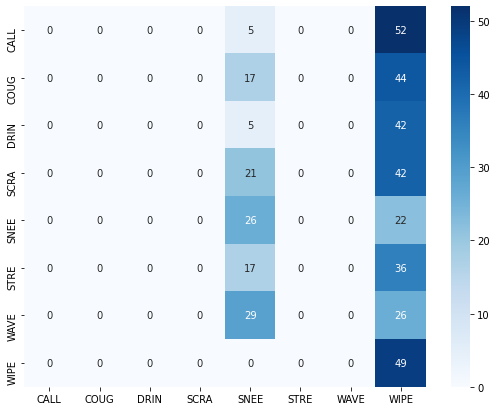

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [21]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

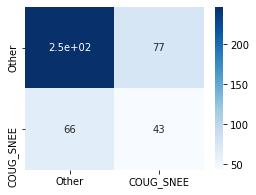

In [22]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [23]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

0.35833333333333334 0.3944954128440367 0.23118279569892472


### 2.5.2 Evaluate model on test dataset

In [26]:
test_preds = model_cnlst.predict_classes(test_data)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
test_true = [mapping[x] for x in test_actions]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

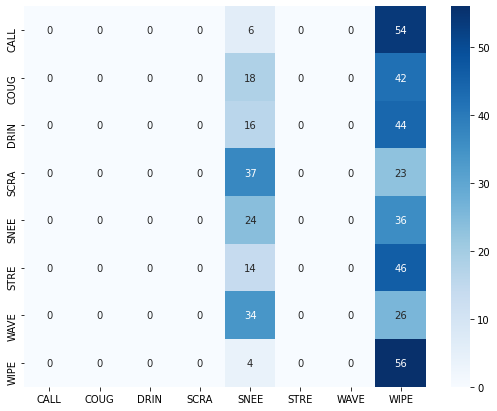

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [29]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

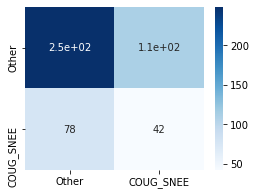

In [30]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [31]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

0.27450980392156865 0.35 0.18181818181818182


## Model 3: Pretrained VGG-16 Features + LSTM

### 3.1 Define model - fewer dense layers

In [54]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import models, Model
from keras.applications import vgg16

frames, channels, rows, columns = 12, 3, 224, 224

video = Input(shape=(frames,rows,columns,channels))
cnn_base = vgg16.VGG16(input_shape=(rows,columns,channels),
                 weights="imagenet",
                 include_top=False)
                 #include_top=True) # want the final dense layers
cnn_base.trainable = False

#cnn = Model(cnn_base.input, cnn_base.layers[-3].output) # -3 is the 4096 layer
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(cnn_base.input, cnn_out)
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(16)(encoded_frames)
#x = Dense(128, activation="relu")(encoded_sequence)
#x = BatchNormalization()(x)
#x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(encoded_sequence)
x = Dropout(0.2)(x)
outputs = Dense(8, activation="softmax")(x) # n_labels = 8

model = Model(video, outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 12, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 12, 512)           14714688  
_________________________________________________________________
lstm_13 (LSTM)               (None, 16)                33856     
_________________________________________________________________
dense_30 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 264       
Total params: 14,749,352
Trainable params: 34,664
Non-trainable params: 14,714,688
_________________________________________

In [55]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=10),
                  keras.callbacks.ModelCheckpoint(
                      filepath='vgg16_lstm_model_fewerDense',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=10
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### 3.2 Train model

In [56]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=60,
                    callbacks=callbacks_list
                    )

Epoch 1/60
51/51 [==============================] - 279s 4s/step - loss: 2.0875 - accuracy: 0.1357 - val_loss: 2.0849 - val_accuracy: 0.1085


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 2/60
51/51 [==============================] - 123s 2s/step - loss: 2.0807 - accuracy: 0.1372 - val_loss: 2.0795 - val_accuracy: 0.1132


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 3/60
51/51 [==============================] - 123s 2s/step - loss: 2.0802 - accuracy: 0.1218 - val_loss: 2.0818 - val_accuracy: 0.1178
Epoch 4/60
51/51 [==============================] - 123s 2s/step - loss: 2.0789 - accuracy: 0.1337 - val_loss: 2.0826 - val_accuracy: 0.1293
Epoch 5/60
51/51 [==============================] - 123s 2s/step - loss: 2.0748 - accuracy: 0.1447 - val_loss: 2.0819 - val_accuracy: 0.1109
Epoch 6/60
51/51 [==============================] - 123s 2s/step - loss: 2.0774 - accuracy: 0.1368 - val_loss: 2.0882 - val_accuracy: 0.1132
Epoch 7/60
51/51 [==============================] - 123s 2s/step - loss: 2.0717 - accuracy: 0.1553 - val_loss: 2.0745 - val_accuracy: 0.1594


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 8/60
51/51 [==============================] - 123s 2s/step - loss: 2.0748 - accuracy: 0.1411 - val_loss: 2.0712 - val_accuracy: 0.1709


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 9/60
51/51 [==============================] - 123s 2s/step - loss: 2.0654 - accuracy: 0.1623 - val_loss: 2.0677 - val_accuracy: 0.1524


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 10/60
51/51 [==============================] - 123s 2s/step - loss: 2.0623 - accuracy: 0.1934 - val_loss: 2.0799 - val_accuracy: 0.1478
Epoch 11/60
51/51 [==============================] - 123s 2s/step - loss: 2.0679 - accuracy: 0.1777 - val_loss: 2.0552 - val_accuracy: 0.1316


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 12/60
51/51 [==============================] - 123s 2s/step - loss: 2.0493 - accuracy: 0.1873 - val_loss: 2.0705 - val_accuracy: 0.1247
Epoch 13/60
51/51 [==============================] - 123s 2s/step - loss: 2.0424 - accuracy: 0.1964 - val_loss: 2.0302 - val_accuracy: 0.1778


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 14/60
51/51 [==============================] - 123s 2s/step - loss: 2.0316 - accuracy: 0.1836 - val_loss: 2.0292 - val_accuracy: 0.2148


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 15/60
51/51 [==============================] - 123s 2s/step - loss: 1.9890 - accuracy: 0.2212 - val_loss: 1.9699 - val_accuracy: 0.2032


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 16/60
51/51 [==============================] - 123s 2s/step - loss: 1.9730 - accuracy: 0.2265 - val_loss: 2.0053 - val_accuracy: 0.2055
Epoch 17/60
51/51 [==============================] - 123s 2s/step - loss: 1.9316 - accuracy: 0.2210 - val_loss: 1.9171 - val_accuracy: 0.2587


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 18/60
51/51 [==============================] - 123s 2s/step - loss: 1.8642 - accuracy: 0.2764 - val_loss: 1.8354 - val_accuracy: 0.2702


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 19/60
51/51 [==============================] - 123s 2s/step - loss: 1.7744 - accuracy: 0.3175 - val_loss: 1.8392 - val_accuracy: 0.2587
Epoch 20/60
51/51 [==============================] - 123s 2s/step - loss: 1.7538 - accuracy: 0.3455 - val_loss: 1.7323 - val_accuracy: 0.3141


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 21/60
51/51 [==============================] - 123s 2s/step - loss: 1.6158 - accuracy: 0.3666 - val_loss: 1.6919 - val_accuracy: 0.2979


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 22/60
51/51 [==============================] - 123s 2s/step - loss: 1.6087 - accuracy: 0.3781 - val_loss: 1.6160 - val_accuracy: 0.3372


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 23/60
51/51 [==============================] - 123s 2s/step - loss: 1.5096 - accuracy: 0.4154 - val_loss: 1.6376 - val_accuracy: 0.3464
Epoch 24/60
51/51 [==============================] - 123s 2s/step - loss: 1.5965 - accuracy: 0.3704 - val_loss: 1.6469 - val_accuracy: 0.3418
Epoch 25/60
51/51 [==============================] - 123s 2s/step - loss: 1.5056 - accuracy: 0.4248 - val_loss: 1.6448 - val_accuracy: 0.3279
Epoch 26/60
51/51 [==============================] - 123s 2s/step - loss: 1.5053 - accuracy: 0.4287 - val_loss: 1.5930 - val_accuracy: 0.3441


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 27/60
51/51 [==============================] - 123s 2s/step - loss: 1.4549 - accuracy: 0.4194 - val_loss: 1.5368 - val_accuracy: 0.3626


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 28/60
51/51 [==============================] - 123s 2s/step - loss: 1.4429 - accuracy: 0.4211 - val_loss: 1.5465 - val_accuracy: 0.3649
Epoch 29/60
51/51 [==============================] - 124s 2s/step - loss: 1.3529 - accuracy: 0.4852 - val_loss: 1.5132 - val_accuracy: 0.3857


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 30/60
51/51 [==============================] - 123s 2s/step - loss: 1.3209 - accuracy: 0.4830 - val_loss: 1.5417 - val_accuracy: 0.3603
Epoch 31/60
51/51 [==============================] - 123s 2s/step - loss: 1.3648 - accuracy: 0.4737 - val_loss: 1.5360 - val_accuracy: 0.3811
Epoch 32/60
51/51 [==============================] - 124s 2s/step - loss: 1.3539 - accuracy: 0.4616 - val_loss: 1.5117 - val_accuracy: 0.4111


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 33/60
51/51 [==============================] - 124s 2s/step - loss: 1.2417 - accuracy: 0.5320 - val_loss: 1.5657 - val_accuracy: 0.3718
Epoch 34/60
51/51 [==============================] - 123s 2s/step - loss: 1.3415 - accuracy: 0.4628 - val_loss: 1.4981 - val_accuracy: 0.4042


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 35/60
51/51 [==============================] - 123s 2s/step - loss: 1.2496 - accuracy: 0.4962 - val_loss: 1.5031 - val_accuracy: 0.3834
Epoch 36/60
51/51 [==============================] - 123s 2s/step - loss: 1.2178 - accuracy: 0.5587 - val_loss: 1.4574 - val_accuracy: 0.4203


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 37/60
51/51 [==============================] - 123s 2s/step - loss: 1.1715 - accuracy: 0.5632 - val_loss: 1.4505 - val_accuracy: 0.4065


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 38/60
51/51 [==============================] - 123s 2s/step - loss: 1.1458 - accuracy: 0.5913 - val_loss: 1.4396 - val_accuracy: 0.3972


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 39/60
51/51 [==============================] - 123s 2s/step - loss: 1.1778 - accuracy: 0.5486 - val_loss: 1.4037 - val_accuracy: 0.4411


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 40/60
51/51 [==============================] - 123s 2s/step - loss: 1.1811 - accuracy: 0.5605 - val_loss: 1.4356 - val_accuracy: 0.4319
Epoch 41/60
51/51 [==============================] - 123s 2s/step - loss: 1.0740 - accuracy: 0.5812 - val_loss: 1.5099 - val_accuracy: 0.4042
Epoch 42/60
51/51 [==============================] - 123s 2s/step - loss: 1.1333 - accuracy: 0.5606 - val_loss: 1.4384 - val_accuracy: 0.4157
Epoch 43/60
51/51 [==============================] - 123s 2s/step - loss: 1.1235 - accuracy: 0.5499 - val_loss: 1.5358 - val_accuracy: 0.4226
Epoch 44/60
51/51 [==============================] - 123s 2s/step - loss: 1.0664 - accuracy: 0.5904 - val_loss: 1.3787 - val_accuracy: 0.4296


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 45/60
51/51 [==============================] - 123s 2s/step - loss: 1.0761 - accuracy: 0.5892 - val_loss: 1.5773 - val_accuracy: 0.3926
Epoch 46/60
51/51 [==============================] - 123s 2s/step - loss: 1.1090 - accuracy: 0.5749 - val_loss: 1.3899 - val_accuracy: 0.4573
Epoch 47/60
51/51 [==============================] - 123s 2s/step - loss: 1.0407 - accuracy: 0.6181 - val_loss: 1.4708 - val_accuracy: 0.4319
Epoch 48/60
51/51 [==============================] - 123s 2s/step - loss: 1.0086 - accuracy: 0.6132 - val_loss: 1.5207 - val_accuracy: 0.4550
Epoch 49/60
51/51 [==============================] - 123s 2s/step - loss: 0.9950 - accuracy: 0.6245 - val_loss: 1.4031 - val_accuracy: 0.4411
Epoch 50/60
51/51 [==============================] - 123s 2s/step - loss: 1.0492 - accuracy: 0.5927 - val_loss: 1.4105 - val_accuracy: 0.4665
Epoch 51/60
51/51 [==============================] - 123s 2s/step - loss: 0.9758 - accuracy: 0.6217 - val_loss: 1.5437 - val_accuracy: 0.4411
Epoch 

INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


INFO:tensorflow:Assets written to: vgg16_lstm_model_fewerDense/assets


Epoch 56/60
51/51 [==============================] - 123s 2s/step - loss: 0.8177 - accuracy: 0.7087 - val_loss: 1.3482 - val_accuracy: 0.4896
Epoch 57/60
51/51 [==============================] - 123s 2s/step - loss: 0.8312 - accuracy: 0.6786 - val_loss: 1.3557 - val_accuracy: 0.4942
Epoch 58/60
51/51 [==============================] - 123s 2s/step - loss: 0.7751 - accuracy: 0.7290 - val_loss: 1.3414 - val_accuracy: 0.5035
Epoch 59/60
51/51 [==============================] - 123s 2s/step - loss: 0.7794 - accuracy: 0.7262 - val_loss: 1.3794 - val_accuracy: 0.4850
Epoch 60/60
51/51 [==============================] - 123s 2s/step - loss: 0.7629 - accuracy: 0.7012 - val_loss: 1.3510 - val_accuracy: 0.5012


### 3.3 Plot train/valid accuracy & loss

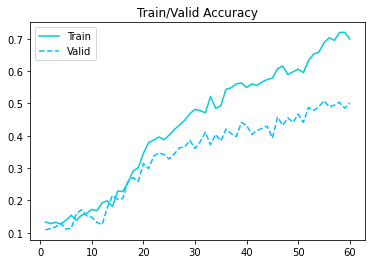

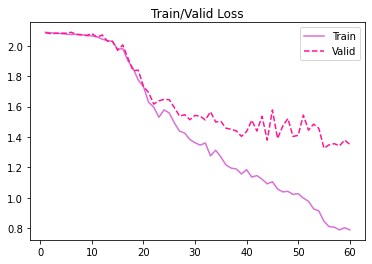

In [57]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

### 3.4 Save model history

In [58]:
###Save history
np.save(os.path.join(base_dir, "model_vgg15_lstm_fewerDense_history"), history.history)
###Save model
model.save(os.path.join(base_dir, "vgg16_lstm_model_fewerDense.h5"))  

### Evaluate model on validation dataset

In [6]:
import keras
model = keras.models.load_model(os.path.join(base_dir, "vgg16_lstm_model_fewerDense.h5"))

val_preds = model.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

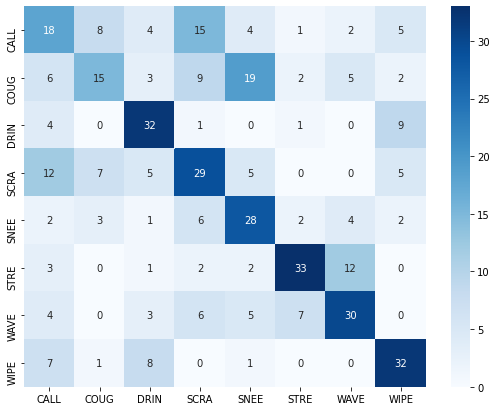

In [7]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [8]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

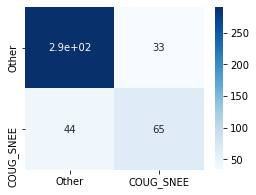

In [9]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [10]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

0.6632653061224489 0.5963302752293578 0.45774647887323944


### 3.5 Evaluate model on test dataset

In [12]:
test_preds = model.predict(test_data)

test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

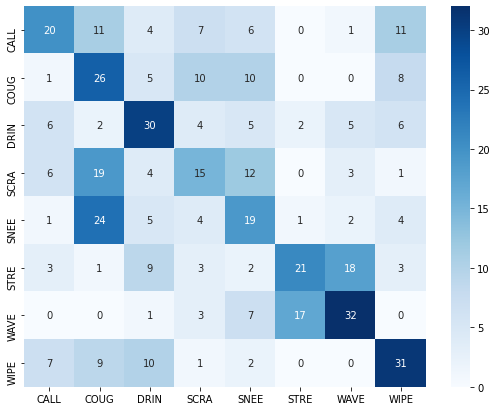

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [14]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

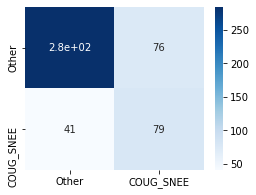

In [15]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [16]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

0.5096774193548387 0.6583333333333333 0.4030612244897959
